In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_02 import *
import torch.nn.functional as F

In [3]:
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
x_train,y_train,x_valid,y_valid = get_data()

In [5]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [6]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [7]:
model = Model(m, nh, 10)

In [8]:
pred = model(x_train)

In [9]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [10]:
sm_pred = log_softmax(pred)

In [11]:
y_train[:3]

tensor([5, 0, 4])

In [12]:
sm_pred[[0,1,2], [5,0,4]]

tensor([-2.2914, -2.3386, -2.3911], grad_fn=<IndexBackward>)

In [13]:
y_train.shape[0]

50000

In [14]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [15]:
loss = nll(sm_pred, y_train)

In [16]:
loss

tensor(2.3102, grad_fn=<NegBackward>)

In [17]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

In [18]:
test_near(nll(log_softmax(pred), y_train), loss)

In [19]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

In [20]:
test_near(logsumexp(pred), pred.logsumexp(-1))

In [21]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [22]:
test_near(nll(log_softmax(pred), y_train), loss)

In [23]:
test_near(F.cross_entropy(pred, y_train), loss)

In [24]:
loss_func = F.cross_entropy

In [25]:
#export
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [26]:
bs = 64
xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([ 0.0185,  0.2210,  0.1601, -0.0864, -0.0804,  0.0445,  0.0379, -0.0735,
         -0.0732,  0.1104], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [27]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3129, grad_fn=<NllLossBackward>)

In [28]:
accuracy(preds, yb)

tensor(0.1406)

In [29]:
lr = 0.5
epochs = 1

In [30]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        # set_trace()
        start_i = i*bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)
        
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()

In [31]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0960, grad_fn=<NllLossBackward>), tensor(0.9375))

In [32]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [33]:
model = Model(m, nh, 10)

In [34]:
for name, l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [35]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [36]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [37]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [38]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2043, grad_fn=<NllLossBackward>), tensor(0.9375))

In [39]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [40]:
mdl = DummyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [41]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

In [42]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [43]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [44]:
model = Model(layers)

In [45]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [46]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [47]:
model = SequentialModel(layers)

In [48]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [49]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2031, grad_fn=<NllLossBackward>), tensor(0.9375))

In [50]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr
                
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [51]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [52]:
opt = Optimizer(model.parameters())

In [53]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [54]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.0999, grad_fn=<NllLossBackward>), tensor(0.9375))

In [55]:
from torch import optim

In [56]:
optim.SGD.step??

In [57]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [58]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.3250, grad_fn=<NllLossBackward>)

In [59]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [60]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.0622, grad_fn=<NllLossBackward>), tensor(1.))

In [61]:
assert acc>0.7

In [62]:
#export
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [63]:
train_ds,valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [64]:
xb, yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [65]:
model, opt = get_model()

In [66]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [67]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1104, grad_fn=<NllLossBackward>), tensor(0.9375))

In [68]:
class DataLoader():
    def __init__(self, ds, bs): self.ds, self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [69]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [70]:
xb,yb = next(iter(valid_dl))
assert xb.shape==(bs,28*28)
assert yb.shape==(bs,)

tensor(3)

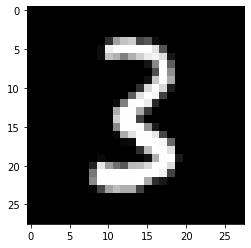

In [71]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [72]:
model,opt = get_model()

In [73]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [74]:
fit()

In [75]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1430, grad_fn=<NllLossBackward>), tensor(0.9688))

In [79]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n, self.bs,self.shuffle = len(ds),bs,shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [80]:
small_ds = Dataset(*train_ds[:10])

In [81]:
s = Sampler(small_ds,3,False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [82]:
s = Sampler(small_ds,3,True)
[o for o in s]

[tensor([4, 2, 5]), tensor([1, 6, 9]), tensor([8, 0, 7]), tensor([3])]

In [83]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [84]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [85]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(3)

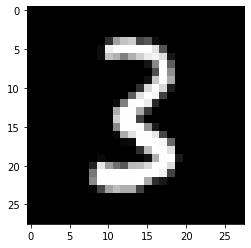

In [87]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(7)

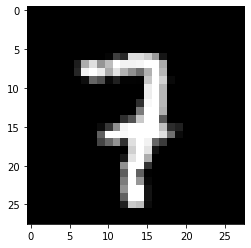

In [88]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(6)

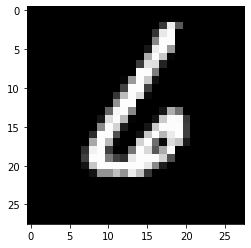

In [89]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [90]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.2323, grad_fn=<NllLossBackward>), tensor(0.9062))

In [91]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [92]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [95]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1626, grad_fn=<NllLossBackward>), tensor(0.9531))

In [96]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [97]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.2319, grad_fn=<NllLossBackward>), tensor(0.9219))

## Validation

In [113]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [114]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [115]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.2726) tensor(0.9110)
1 tensor(0.1268) tensor(0.9612)
2 tensor(0.1104) tensor(0.9692)
3 tensor(0.1245) tensor(0.9634)
4 tensor(0.1410) tensor(0.9604)


In [116]:
assert acc>0.9

In [117]:
!python notebook2script.py 03_minibatch_training.ipynb

Converted 03_minibatch_training.ipynb to exp/nb_03.py
